# DS5559 Naive Bayes Wine Reviews

## Synopsis

We attempt a Naive Bayes classifier for the sentiment of a corpus of wine reviews. We use the score of the review as our sentiment value, assuming that a bad review will have negative sentiment and a good review will have positive sentiment.

## Configuration

In [1]:
src_file = 'winereviews.csv'

# Set Hyperparameters
params = dict(
    qntile_B = .1,
    qntile_A = .9,
    n_sets = 4,
    smooth_alpha = 1,
    binary_counts = True
)

## Libraries

In [2]:
import pandas as pd
import numpy as np
from numpy.random import randint
from textman import create_tokens_and_vocab

## Pragmas

In [3]:
%matplotlib inline

# Process

## PREPROCESSING

### Import raw review data

In [4]:
try:
    docs = pd.read_csv('winereviews.csv', index_col='doc_id')
except FileNotFoundError as e:
    print(e)

In [5]:
docs.head()

,doc_content,points
doc_id,,
0,"Aromas include tropical fruit, broom, brimston...",87
1,"This is ripe and fruity, a wine that is smooth...",87
2,"Tart and snappy, the flavors of lime flesh and...",87
3,"Pineapple rind, lemon pith and orange blossom ...",87
4,"Much like the regular bottling from 2012, this...",87


### Clip DOC table by quantile

We only want reviews that are very good or very bad.

In [6]:
bound_A = int(docs.points.quantile(params['qntile_A']))
bound_B = int(docs.points.quantile(params['qntile_B']))
docs = docs[(docs.points <= bound_B) | (docs.points >= bound_A)].copy()

In [7]:
print('A:', bound_A, '\nB:', bound_B)

A: 93 
B: 84


### Convert DOC points feature to A and B labels

In [8]:
docs.loc[docs.points >= bound_A, 'doc_label'] = 'A'
docs.loc[docs.points <= bound_B, 'doc_label'] = 'B'

## TRAINING

### Split out training and test sets from DOC 

We randomly assign each doc a value from 0 to 9, and then select one group for testing, i.e. 10%.

In [9]:
docs['set'] = randint(0,params['n_sets'], len(docs.index))
training = docs.query('set != 0').copy()
testing = docs.query('set == 0').copy()

In [10]:
testing.sample(5)

,doc_content,points,doc_label,set
doc_id,,,,
121745,There's a bland greenness to this wine that de...,83,B,0
31212,This excellent vintage of Coronato (a hearty b...,93,A,0
123761,"Of the three Cherubino 2010 Cabernets, I sligh...",94,A,0
80374,"With zesty acidity, ripe raspberry and cherry ...",84,B,0
7483,"Really too ripely sweet and hot for comfort, e...",83,B,0


### Get TOKEN and VOCAB from training corpus

We use our text parsing library tokenize. We don't need the vocab table since we won't be using its  stats.

In [11]:
tokens, _ = create_tokens_and_vocab(training, src_col='doc_content')

In [12]:
tokens.head()

token     term_str  term_id
doc_id sent_id token_id                                   
337    0       1                easy         easy     4542
               3            inviting     inviting     7312
               4           selection    selection    12279
               8         mentholated  mentholated     8684
               9              streak       streak    13354

### Add sentiment labels to TOKENs

We now transfer the doc label to the tokens, by **transitive inheritance**.

In [13]:
tokens = tokens.join(training.doc_label, on='doc_id')

In [14]:
tokens.head()

token     term_str  term_id doc_label
doc_id sent_id token_id                                             
337    0       1                easy         easy     4542         B
               3            inviting     inviting     7312         B
               4           selection    selection    12279         B
               8         mentholated  mentholated     8684         B
               9              streak       streak    13354         B

### Create VOCAB from TOKEN

In [15]:
vocab = tokens.groupby('term_id').term_str.value_counts()\
    .to_frame().rename(columns={'term_str':'n'})
vocab = vocab.reset_index().set_index('term_id')
vocab['f'] = vocab.n / vocab.n.sum()

In [16]:
vocab.sort_values('n', ascending=False).head()

,term_str,n,f
term_id,,,
15544,wine,11782,0.026290
5507,flavors,8946,0.019962
5839,fruit,6504,0.014513
9877,palate,5075,0.011324
970,aromas,4828,0.010773


### Adjust TOKENS table

In [17]:
tokens = tokens.reset_index()[['doc_label', 'doc_id', 'term_id']]

In [18]:
tokens.head(5)

,doc_label,doc_id,term_id
0,B,337,4542
1,B,337,7312
2,B,337,12279
3,B,337,8684
4,B,337,13354


### Compute Priors

$$
\hat{P}(c) = \dfrac{N_{c}}{N_{d}}
$$

We compute the probability of each label in the corpus.

In [19]:
priors = training['doc_label'].value_counts() / training.shape[0]

In [20]:
priors

A    0.502365
B    0.497635
Name: doc_label, dtype: float64

### Compute Likelihoods 

$$
\hat{P}(w_i|c) = \dfrac{count(w_i,c)}{\sum_{w \in V} count(w,c)}
$$

$$
\hat{P}(w_i|c) = \dfrac{count(w_i,c)+1}{\sum_{w \in V} (count(w,c)+1)} = \dfrac{count(w_i,c)+1}{(\sum_{w \in V} count(w,c))+|V|} 
$$

Now we compute the probability of a token given the label. This will in effect product two language models, one for each label. Key idea = **the likelihoods are language models** (see Pearl for interpretation of likelihoods).

In [21]:
likelihoods = tokens.groupby(['term_id','doc_label']).count().unstack().fillna(0)
likelihoods.columns = likelihoods.columns.droplevel(0)
likelihoods = likelihoods + params['smooth_alpha']
likelihoods = likelihoods / likelihoods.sum()

In [22]:
likelihoods.head()

doc_label,A,B
term_id,,
339,0.000021,0.000006
342,0.000014,0.000006
345,0.000014,0.000006
346,0.000003,0.000029
348,0.000014,0.000006


### Associate classes with terms

In [23]:
likelihoods['term_str'] = vocab['term_str']
likelihoods['class'] = likelihoods[['A','B']].idxmax(1)

In [24]:
likelihoods.head()

doc_label,A,B,term_str,class
term_id,,,,
339,0.000021,0.000006,aaron,A
342,0.000014,0.000006,abbey,A
345,0.000014,0.000006,abbott,A
346,0.000003,0.000029,abbreviated,B
348,0.000014,0.000006,abeja,A


In [25]:
likelihoods['class'].value_counts()

A    4162
B    3085
Name: class, dtype: int64

### Aside: Create Sentiment Lexicon

In [26]:
sentilex = (np.sign(likelihoods['A'] - likelihoods['B'])).to_frame().rename(columns={0:'polarity'})
sentilex['valence'] = (likelihoods['A'] - likelihoods['B']) * 1000
sentilex['term_str'] = vocab.term_str
sentilex = sentilex.set_index('term_str')

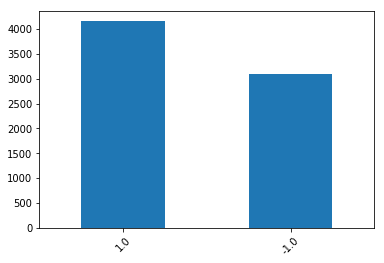

In [27]:
sentilex.polarity.value_counts().plot(kind='bar', rot=45)

In [28]:
sentilex.sort_values('valence', ascending=False).head(10)

,polarity,valence
term_str,,
black,1.0,7.533149
rich,1.0,5.840329
ripe,1.0,4.667671
drink,1.0,4.632183
years,1.0,4.517829
tannins,1.0,4.330211
dark,1.0,3.943655
vineyard,1.0,3.485100
concentrated,1.0,3.424703


In [29]:
sentilex.sort_values('valence', ascending=True).head(10)

,polarity,valence
term_str,,
flavors,-1.0,-17.592674
aromas,-1.0,-8.699193
finish,-1.0,-8.421611
sweet,-1.0,-6.056741
simple,-1.0,-5.649083
green,-1.0,-5.259729
soft,-1.0,-5.232785
light,-1.0,-4.663538
like,-1.0,-4.076981


## TESTING

$$
c_{NB} = \arg\max \log{P(c)} + \sum_{id=1}^{id_{max}} \log{P(token_{id}|c)}
$$


### Get test corpus

Note that we replace the vocabulary IDs with the old.

In [30]:
test, _ = create_tokens_and_vocab(testing, src_col='doc_content')
test['term_id'] = test.term_str.map(vocab.reset_index().set_index('term_str').term_id)
test = test.dropna()
test['term_id'] = test['term_id'].astype('int')

In [31]:
test.head()

token term_str  term_id
doc_id sent_id token_id                           
336    0       0          Gritty   gritty     6388
               1         heavily  heavily     6649
               2         roasted  roasted    11689
               3          aromas   aromas      970
               7          herbal   herbal     6703

### OLD: Convert corpus to BOW

In [32]:
# test_docs = test.groupby(['doc_id','term_id']).term_id.count()\
#     .unstack().apply(lambda x: x.dropna().index.astype('int').tolist(), 1)\
#     .to_frame().rename(columns={0:'bow'})
# test_docs['doc_label'] = testing.doc_label
# if params['binary_counts']:
#     # set() forces BOW to consist of only one token for each term
#     test_docs['bow'] = test_docs.bow.apply(lambda x: set(x))

### Compute logs of likelihoods 

In [33]:
loglls = np.log(likelihoods[['A','B']])

### Reduce test set to single instances of words per doc

In [34]:
T1 = test.reset_index()\
    .drop_duplicates(['doc_id','term_id'])[['doc_id','term_id','term_str']]\
    .join(loglls[['A','B']], on='term_id', how='left')\
    .set_index(['doc_id','term_id'])

In [35]:
T1.head()

term_str         A         B
doc_id term_id                             
336    6388      gritty -9.736710 -7.335668
       6649     heavily -9.736710 -8.046515
       11689    roasted -7.405138 -6.990462
       970       aromas -4.940434 -4.144542
       6703      herbal -7.399440 -5.458483

### Compute POSTERIORs and make prediction

In [36]:
testing['A'] = np.exp(T1.A.unstack().sum(1) + np.log(priors.A))
testing['B'] = np.exp(T1.B.unstack().sum(1) + np.log(priors.B))
testing['prediction'] = testing[['A','B']].idxmax(1)

In [37]:
testing.head(5)

,doc_content,points,doc_label,set,A,B,prediction
doc_id,,,,,,,
336,"Gritty, heavily roasted aromas of peanuts and ...",83,B,0,2.524275e-89,1.193186e-74,B
341,"Plummy and hinting at black cherry, this wine ...",82,B,0,6.963862e-44,3.614248e-40,B
344,"Aromas of pumpkin, squash and corn chips are s...",80,B,0,1.968511e-83,2.259157e-69,B
346,"This deep brown wine smells like a damp, mossy...",98,A,0,2.059005e-88,1.127278e-92,A
351,This amber-colored Hungarian stunner has ether...,96,A,0,4.147686e-114,1.629710e-112,B


## EVALUATION

In [38]:
testing['result'] = testing.doc_label == testing.prediction
T, F = testing.result.value_counts()
grade = round(T/(T+F) * 100, 4)
CM = testing.reset_index().groupby(['prediction','doc_label']).doc_id.count().unstack().fillna(0)

In [39]:
grade

96.0932

In [40]:
CM

doc_label,A,B
prediction,,
A,2994,180
B,58,2860


### Precision

In [41]:
CM / CM.sum(1)

doc_label,A,B
prediction,,
A,0.943289,0.061686
B,0.018273,0.980123


### Recall

In [42]:
CM / CM.sum()

doc_label,A,B
prediction,,
A,0.980996,0.059211
B,0.019004,0.940789


## Predicting by Lexicon

In [47]:
test2 = test.join(sentilex, on='term_str', how='left').sort_index()

In [48]:
test2.head()

token term_str  term_id  polarity   valence
doc_id sent_id token_id                                               
336    0       0          Gritty   gritty     6388      -1.0 -0.592794
               1         heavily  heavily     6649      -1.0 -0.261141
               2         roasted  roasted    11689      -1.0 -0.312500
               3          aromas   aromas      970      -1.0 -8.699193
               7          herbal   herbal     6703      -1.0 -3.648420

In [49]:
testing['lexpredict'] = np.sign(test2.groupby('doc_id').valence.sum())
testing.loc[testing.lexpredict > 0, 'lexpredict_label'] = 'A'
testing.loc[testing.lexpredict <= 0, 'lexpredict_label'] = 'B'

In [50]:
testing.head()

,doc_content,points,doc_label,set,A,B,prediction,result,lexpredict,lexpredict_label
doc_id,,,,,,,,,,
336,"Gritty, heavily roasted aromas of peanuts and ...",83,B,0,2.524275e-89,1.193186e-74,B,True,-1.0,B
341,"Plummy and hinting at black cherry, this wine ...",82,B,0,6.963862e-44,3.614248e-40,B,True,-1.0,B
344,"Aromas of pumpkin, squash and corn chips are s...",80,B,0,1.968511e-83,2.259157e-69,B,True,-1.0,B
346,"This deep brown wine smells like a damp, mossy...",98,A,0,2.059005e-88,1.127278e-92,A,True,1.0,A
351,This amber-colored Hungarian stunner has ether...,96,A,0,4.147686e-114,1.629710e-112,B,False,-1.0,B


In [51]:
testing['result2'] = testing.doc_label == testing.lexpredict_label

In [52]:
testing.result2.value_counts() / testing.result2.value_counts().sum()

True     0.7761
False    0.2239
Name: result2, dtype: float64

In [53]:
T2, F2 = testing.result2.value_counts()
grade2 = round(T2/(T2+F2) * 100, 4)
CM2 = testing.reset_index().groupby(['lexpredict_label','doc_label']).doc_id.count().unstack().fillna(0)

In [54]:
grade2

77.61

In [55]:
CM2

doc_label,A,B
lexpredict_label,,
A,1852,164
B,1200,2876


In [56]:
testing.head()

,doc_content,points,doc_label,set,A,B,prediction,result,lexpredict,lexpredict_label,result2
doc_id,,,,,,,,,,,
336,"Gritty, heavily roasted aromas of peanuts and ...",83,B,0,2.524275e-89,1.193186e-74,B,True,-1.0,B,True
341,"Plummy and hinting at black cherry, this wine ...",82,B,0,6.963862e-44,3.614248e-40,B,True,-1.0,B,True
344,"Aromas of pumpkin, squash and corn chips are s...",80,B,0,1.968511e-83,2.259157e-69,B,True,-1.0,B,True
346,"This deep brown wine smells like a damp, mossy...",98,A,0,2.059005e-88,1.127278e-92,A,True,1.0,A,True
351,This amber-colored Hungarian stunner has ether...,96,A,0,4.147686e-114,1.629710e-112,B,False,-1.0,B,False
